In [1]:
import base64
import gzip
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
def load_grayscale_image(image_path: str) -> np.ndarray | None:
	try:
		image = Image.open(image_path).convert("L")
		return np.array(image) / 255
	except:
		return None

def show_image(image: np.ndarray) -> None:
	plt.imshow(image, cmap = "gray", vmin = 0, vmax = 1)
	plt.show()

In [3]:
def mean_pool(image: np.ndarray, size: tuple[int, int]) -> np.ndarray:
	width, height = size
	thumbnail = np.zeros(size)
	block_height = image.shape[0] / height
	block_width = image.shape[1] / width
	if block_height < 1 or block_width < 1:
		raise ValueError(f"Blueprint's size can not be larger than original image.")
	for block_y in range(height):
		for block_x in range(width):
			block = image[
				int(block_y * block_height) : int((block_y + 1) * block_height),
				int(block_x * block_width) : int((block_x + 1) * block_width)
			]
			thumbnail[block_y, block_x] = np.mean(block)
	return thumbnail

In [4]:
def brightness_remap(image: np.ndarray, min_lightness: float, max_lightness: float) -> np.ndarray:
	normalized_image =  (image - image.min()) / (image.max() - image.min())
	return normalized_image * (max_lightness - min_lightness) + min_lightness

In [5]:
def posterize(image: np.ndarray, palette: list[float]) -> np.ndarray:
	palette = np.array(palette)
	posterized = image.copy()
	height, width = posterized.shape
	for y in range(height):
		for x in range(width):
			real_grayscale = posterized[y, x]
			posterized_grayscale = palette[np.argmin(np.abs(palette - real_grayscale))]
			posterized[y, x] = posterized_grayscale
	return posterized

def dither(image: np.ndarray, palette: list[float]) -> np.ndarray:
	palette = np.array(palette)
	dithered = image.copy()
	height, width = dithered.shape
	for y in range(height):
		for x in range(width):
			real_grayscale = dithered[y, x]
			posterized_grayscale = palette[np.argmin(np.abs(palette - real_grayscale))]
			dithered[y, x] = posterized_grayscale
			if y == height - 1 or x == 0 or x == width - 1:
				continue
			error = real_grayscale - posterized_grayscale
			dithered[y,     x + 1] += error * 7 / 16
			dithered[y + 1, x - 1] += error * 3 / 16
			dithered[y + 1, x    ] += error * 5 / 16
			dithered[y + 1, x + 1] += error * 1 / 16
	return dithered

In [6]:
def parse_blueprint(blueprint: str) -> dict:
	prefix = "SHAPEZ2-3-"
	blueprint_base64 = blueprint[len(prefix):]
	blueprint_compressed = base64.b64decode(blueprint_base64)
	blueprint_json = json.loads(gzip.decompress(blueprint_compressed).decode("UTF-8"))
	return blueprint_json

def extract_palette(blueprint: str, grayscales: list[int]) -> dict[float, str]:
	buildings: list[dict[str]] = parse_blueprint(blueprint)["BP"]["Entries"]
	grouped_buildings: defaultdict[int, list[dict]] = defaultdict(list)
	for building in buildings:
		if "X" not in building:
			building["X"] = 0
		building_offset = building["X"]
		building["X"] = "#X"
		building["Y"] = "#Y"
		grouped_buildings[building_offset].append(building)

	palette: dict[float, str] = {}
	building_offsets = list(grouped_buildings.keys())
	min_building_offset = min(building_offsets)
	max_building_offset = max(building_offsets)
	if len(grayscales) != max_building_offset - min_building_offset - 1:
		raise ValueError(f"Length of grayscales ({len(grayscales)}) doesn't match the length of building array ({max_building_offset - min_building_offset - 1}).")
	for palette_index, building_offset in enumerate(range(min_building_offset + 1, max_building_offset)):
		grayscale = grayscales[palette_index] / 255
		if building_offset not in grouped_buildings:
			palette[grayscale] = ""
			continue
		palette_buildings = json.dumps(grouped_buildings[building_offset], separators = (",", ":"))[1:-1]
		palette_buildings = palette_buildings.replace("{", "{{").replace("}", "}}")
		palette_buildings = palette_buildings.replace("#X", "{0}").replace("#Y", "{1}")
		palette[grayscale] = palette_buildings
	return palette

In [7]:
def build_blueprint(image: np.ndarray, palette_mapping: dict[float, str]) -> str:
	blueprint_template = '{{"V":1122,"BP":{{"$type":"Building","Icon":{{"Data":[null,null,null,null]}},"Entries":[{}],"BinaryVersion":1122}}}}'
	buildings: list[str] = []
	height, width = image.shape
	for y in range(height):
		for x in range(width):
			grayscale = image[y, x]
			building_template = palette_mapping[grayscale]
			building = building_template.format(x, y)
			if building != "":
				buildings.append(building)
	blueprint_json = blueprint_template.format(",".join(buildings))
	blueprint_compressed = gzip.compress(blueprint_json.encode("UTF-8"))
	blueprint_base64 = base64.b64encode(blueprint_compressed).decode("ASCII")
	return "SHAPEZ2-3-" + blueprint_base64 + "$"

In [8]:
def generate(
	grayscale_image: np.ndarray,
	size: tuple[int, int] = (54, 54),
	palette_mapping: dict[float, str] | None = None,
	brightness_correction: tuple[float, float] | None = None,
	dithering: bool = True,
	plot_image: bool = False
) -> str:
	if palette_mapping is None:
		palette_mapping = extract_palette(
			"SHAPEZ2-3-H4sIAFc7m2gA/5yUX2uDMBTFv8tlj+7BP2u7PLZuUNiDTOkGow+h3rUXQpQkDkT87tPZgoVJryUQCPmdmxNychvYgfD9IPBgnYBo4MHVJYKAdUUqJ30ED7aHQvdbsXQSxBdQtxaXfQuerpQaJrAnWaLYVMOAfevBi3aG0HbCBj5BPC49yLr6mZH2FOO3rJTbaodGS7WThqR20HoDupiFvnUXGQQfZPDMrw3lR5xSPd2liv5UwaBKqMSNKaydosPxGUyaWzuYVXteVS7t8zmmV/7h/tgp9/2ujLyqivKkMO4dD0g/aKZFHEPh/AD2fEy2VLK+kfFoDnx2kpaKXEf4WRFOoFchuvBZ2v/kCUU075ar8SsxDIX3/EpuXFfsnrIY2+bmZPmvKEWdT0qeGY72XXsmLU29Q2Opb8d9z27bXwEGAKfFB+6/BQAA$",
			[12, 24, 32, 42, 50, 64, 72, 82, 88, 94, 106, 120, 135, 160, 170, 180]
		)
	palette = list(palette_mapping.keys())
	thumbnail = mean_pool(grayscale_image, size)
	brightness_range = (palette[0], palette[-1]) if brightness_correction is None else brightness_correction
	corrected_thumbnail = brightness_remap(thumbnail, *brightness_range)
	posterized_thumbnail = (dither if dithering else posterize)(corrected_thumbnail, palette)
	if plot_image:
		show_image(posterized_thumbnail)
	blueprint = build_blueprint(posterized_thumbnail, palette_mapping)
	return blueprint

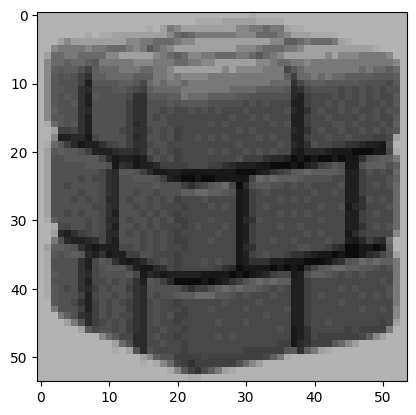

SHAPEZ2-3-H4sIAN7TmmgC/7WdTa8lx5Ge/8uBl1ycjI/84FKWDQwwC2FIyDaMWTSG7VEDRItoUgYEQf/dLZq8PPdUlbreJ25tBAnquBFVJzIy4qm3sv52++Pt69bMvrr97g+3r/92+y8//fWH97evb7/7y4fvv/vw8T9vX93+5T/+/PEf/9fv3/307vb1//74l++//+r1f/z737+6/bePP3368P7Hz//gb7f/+fkP3D9b/uvt689/+NvP/+ubH77/8NNP7z+1b//s//Lx83/5+O77P7779OHdx58+/7v/9fO///tX/9+yYUvDlo4tA1smtuzYcmDLiS0Xz4RCEvEsajyNGs+jxhOp8UxqPJUaz6XGk6nxbDKeTVaoSTybjGeT8Wwynk3Gs8l4NhnPJuPZ5Dyb/HU2/ffv//Lhuz/8+dNP37z/+N37T1+0LuxyPKGcJ5TzhHKeUM4TynlCOU+o4AkVvDwFz6YoNE08m4JnU/BsCp5NwbMpeDYlz6bk2ZQ8m5Jnk3qpDY8aDY8aDY8aDY8aDY8aDY8aDY8aDY8aDY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8ajY8a7WjUONWStqNpQ7XOknUvWY996397/x/vP/zfE/azaL9q9k9TiG7fivZWufteyjovZZ2Xss55MXNezJwXM+fFLHgxC17MghezKLRYfGsMvjUGz6bg2RQ8m4JnU/JsSp5NybMpeTapl2p4MDE8mBgeTAwPJoYHE8ODieHBxPBgYngwMT6YGB9MjA8mxgcT44OJ8cHEjgaTU52A8dnEjmaTk82XvR5Q/mH5Pz58ev/79//n3V++/+l3nz5895/vv1gkWs2zWdHei/ZRtM+ifS/aj6J9MXN+bvtR5vzc8DNLL1l+vtpG7QN7TmxZzBAflaLks2TNd6vgu1Xw3Sr4bhWFrofvVsF3q+CNT/CtKnjrEzybkmdT8mxKnk3Js0m9VMezguNZwf

In [9]:
image_path = "./tests/test4.webp"

blueprint = generate(
	load_grayscale_image(image_path),
	dithering = True,
	plot_image = True
)
print(blueprint)